In [1]:
#Importações
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image

Abaixo temos os parâmetros escolhidos para realizar a simulação. Todos os parametros foram escolhidos de acordo com o artigo base (com exceção do número de iterações)

In [2]:
wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 μm
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numérica
num_iter = 200       # número de iterações

A seção abaixo trata de carregar e processar a imagem alvo que será reconstruída

In [3]:
def load_and_preprocess_image(image_path, target_size=(450, 450)):
    """
    Carrega e pré-processa a imagem alvo usando PIL
    """
    try:
        # Carrega a imagem
        image = Image.open(image_path).convert('L')  # Converte para escala de cinza
        
        # Redimensiona para o tamanho alvo
        image = image.resize(target_size, Image.LANCZOS)
        
        # Converte para array numpy e normaliza
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        
        return image_array
    
    except FileNotFoundError:
        # Se a imagem não existir, cria uma imagem de teste
        print("Imagem 'ufabc.png' não encontrada. Criando imagem de teste...")
        target_image = np.zeros((450, 450))
        # Cria um padrão simples de teste (letras UFABC)
        target_image[150:300, 100:200] = 1.0  # Barra vertical
        target_image[150:200, 200:350] = 1.0  # Barra horizontal superior
        target_image[250:300, 200:350] = 1.0  # Barra horizontal inferior
        return target_image

Aplicação da técnica "Zero Padding" à imagem. 
Alinhamos a imagem ao centro a partir de uma matriz 900x900 (preenchendo o resto com zeros com dtype complex).
Essa técnica aumenta a resolução, frequência e reduz o aliasing quando aplicamos FFTs e propagação.
No artigo base esse método é implementado justamente para suprimir o aliasing e obter melhor reconstrução.
Um trade-off que essa metodologia envolve é maior consumo de memória e tempo para rodar a aplicação. No entanto vale a pena.

In [4]:
def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding à imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)
    
    # Coloca a imagem original no centro
    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0], 
                start_col:start_col+original_size[1]] = image
    
    return padded_image, original_size


A Função abaixo cria um "low-pass filter" que consiste numa máscara circular no domínio da frequência: 1 dentro do raio e 0 fora. 
A lente objetiva só captura componentes espaciais até uma frequência espacial máxima de f = NA/λ, essa frquência aparece explicitamente no artigo como (fx^2 + fy^2) ≤ (NA/λ)^2. Com isso temos que valores (fx^2 + fy^2) > (NA/λ)^2 não contribuem para a imagem pois não são capturados.

In [5]:
def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numérica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    
    # Calcula a frequência de corte
    f_cutoff = NA / wavelength
    
    # Cria máscara circular
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)
    
    return filter_mask

Aqui temos a função que define o algoritmo AS (Angular Spectrum). Ele propaga um campo complexo U(x,y) ao longo de z. N domínio de Fourier a propagação é uma multiplicação por um Kernel de fase H(fx,fy).
para root_term < 0 temos que o valor da raiz se torna imaginário, a interpretação física corresponde a ondas evanescentes, ou seja, decai exponencialmente com z. 

In [6]:
def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando método do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape
    
    # Calcula o kernel de propagação
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')
    
    # Calcula o termo dentro da raiz quadrada
    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    
    # Aplica tratamento para valores negativos (ondas evanescentes)
    root_term[root_term < 0] = 0  # Define valores negativos como zero
    
    # Kernel de propagação
    H = np.exp(1j * k * z * np.sqrt(root_term))
    
    # Aplica filtro se fornecido
    if filter_mask is not None:
        H = H * filter_mask
    
    # Propaga o campo
    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)
    
    return U_prop

Aqui definimos a correlação de pearson que é usada para calcular a semelhança da imagem alvo com a imagem reconstruída. 
No artigo essa correlação é usada como FoM (Figure of Merit)

In [7]:
def calculate_correlation(target, reconstructed):
    """
    Calcula a correlação de Pearson entre duas imagens (valores reais)
    """
    # Garante que os arrays são reais
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()
    
    # Calcula correlação de Pearson
    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]
    
    # Se houver NaN, retorna 0
    if np.isnan(correlation):
        return 0.0
    
    return float(correlation)

Aqui removemos o Padding e retornamos a região central com as dimensões originais 450x450 pois tudo o que foi propagado e calculado estava em matriz maior para evitar o aliasing. No fim queremos exibir apenas a região central e essa função isola ela

In [8]:
def extract_center(image, original_size):
    """
    Extrai região central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

Aqui temos a aplicação do GS com o resto das outras funções.

1- Aplicamos o padding na imagem alvo

2- Aplicação do filto LP 

3- Inicialização com fase aleatória.

4- iteramos n vezes os seguintes processos: Propagação de U até U_Image, Extração da amplitude e fase, cálculo da correlação, imposição da restrição do plano da imagem, propagação de volta e imposição de restrição no plano do holograma.

A amplitude foi forçada a ser unitária pois o artigo trabalha com um holograma de fase única.


In [9]:
def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    """
    # Aplica zero-padding
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape
    
    # Cria filtro passa-baixa
    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)
    
    # Inicializa com fase aleatória
    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)
    
    # Lista para armazenar métricas de convergência
    correlations = []
    
    for i in range(num_iter):
        # 1. Propaga para o plano da imagem (Fresnel)
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)
        
        # 2. Mantém a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)
        
        # Calcula correlação para monitorar convergência
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)
        
        # Correlação de Pearson (garantindo valores reais)
        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)
        
        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)
        
        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)
        
        # 4. Mantém a fase, atualiza amplitude com incidente (unitária)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram)  # Amplitude unitária
        
        if (i + 1) % 10 == 0:
            print(f"Iteração {i+1}/{num_iter}, Correlação: {corr:.4f}")
    
    # Extrai a fase final (apenas região central sem padding)
    phase_final = extract_center(np.angle(U), original_size)
    
    return phase_final, correlations

A função abaixo usa o mapa de fase obtido para criar o campo, usar padding no tamanho original, aplicar o filtro LP e propagar para o plano da imagem. No fim retorna a amplitude da região central.
Testamos se o mapa de fase final reconstrói a imagem alvo quando iluminado com onda incidente uniforme e propagado até z

In [10]:
def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))
    
    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)
    
    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)
    
    # Extrai região central
    reconstructed = extract_center(np.abs(reconstructed), original_size)
    
    return np.real(reconstructed)  # Garante valor real

Aqui temos os processamentos de imagens e os plots de saída

Carregando e pré-processando imagem...
Executando algoritmo de Gerchberg-Saxton...


C:\Users\humberto25043\AppData\Local\Temp\ipykernel_9340\3982504833.py:10: DeprecationWarning: LANCZOS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.LANCZOS)


Iteração 10/200, Correlação: 0.9457
Iteração 20/200, Correlação: 0.9535
Iteração 30/200, Correlação: 0.9562
Iteração 40/200, Correlação: 0.9579
Iteração 50/200, Correlação: 0.9590
Iteração 60/200, Correlação: 0.9596
Iteração 70/200, Correlação: 0.9603
Iteração 80/200, Correlação: 0.9607
Iteração 90/200, Correlação: 0.9612
Iteração 100/200, Correlação: 0.9615
Iteração 110/200, Correlação: 0.9618
Iteração 120/200, Correlação: 0.9619
Iteração 130/200, Correlação: 0.9621
Iteração 140/200, Correlação: 0.9622
Iteração 150/200, Correlação: 0.9624
Iteração 160/200, Correlação: 0.9626
Iteração 170/200, Correlação: 0.9628
Iteração 180/200, Correlação: 0.9630
Iteração 190/200, Correlação: 0.9631
Iteração 200/200, Correlação: 0.9632
Reconstruindo imagem...


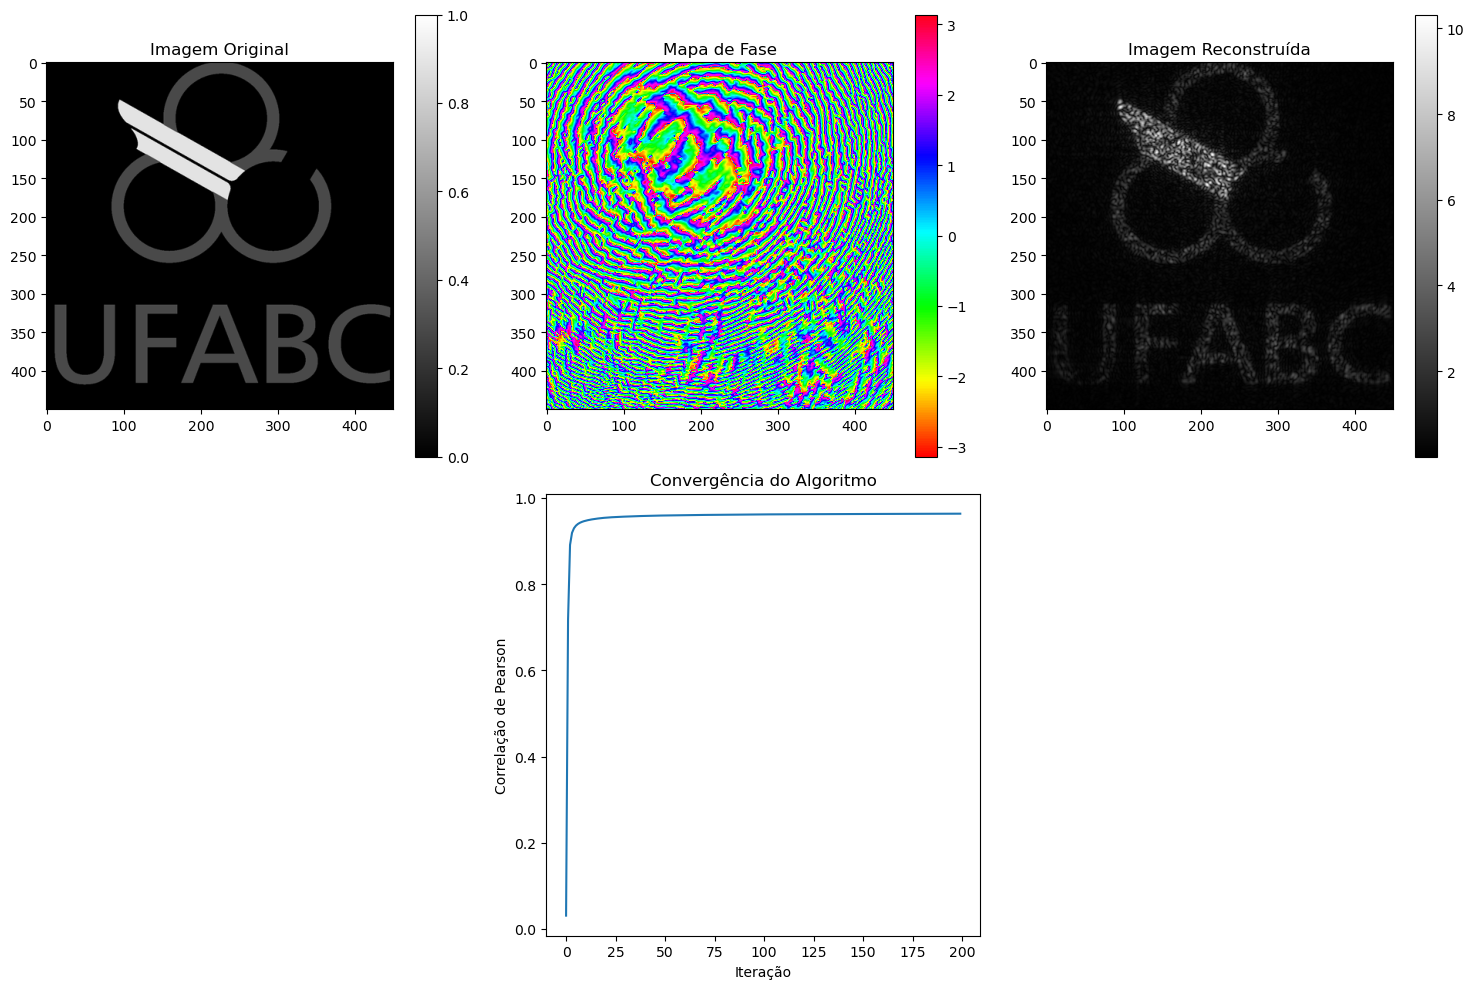

Correlação final: 0.9632
Mapa de fase salvo em 'phase_map_x_polarization.txt'
Resultados visuais salvos em 'resultados_holografia.png'


In [11]:
# Carrega e pré-processa a imagem
print("Carregando e pré-processando imagem...")
target_image = load_and_preprocess_image('ufabc.png', target_size=(450, 450))

# Executa algoritmo de Gerchberg-Saxton
print("Executando algoritmo de Gerchberg-Saxton...")
phase_map, correlations = gerchberg_saxton_angular_spectrum(
    target_image, wavelength, z, dx, NA, num_iter
)

# Reconstrói imagem para verificação
print("Reconstruindo imagem...")
reconstructed_image = reconstruct_image(phase_map, wavelength, z, dx, NA)

# Visualização dos resultados
plt.figure(figsize=(15, 10))

# Imagem original
plt.subplot(2, 3, 1)
plt.imshow(target_image, cmap='gray')
plt.title('Imagem Original')
plt.colorbar()

# Mapa de fase
plt.subplot(2, 3, 2)
plt.imshow(phase_map, cmap='hsv')
plt.title('Mapa de Fase')
plt.colorbar()

# Imagem reconstruída
plt.subplot(2, 3, 3)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Imagem Reconstruída')
plt.colorbar()

# Correlação vs iteração
plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.xlabel('Iteração')
plt.ylabel('Correlação de Pearson')
plt.title('Convergência do Algoritmo')




plt.tight_layout()
plt.savefig('resultados_holografia.png', dpi=300)
plt.show()

# Salva resultados
np.savetxt('phase_map_x_polarization.txt', phase_map)
np.savetxt('correlations.txt', correlations)

print(f"Correlação final: {correlations[-1]:.4f}")
print("Mapa de fase salvo em 'phase_map_x_polarization.txt'")
print("Resultados visuais salvos em 'resultados_holografia.png'")